# FIT5202 Assignment2A
#### Student ID: 31968376

Date: 27/01/2021

Environment: Python 3.7.9 and Jupyter notebook

Package used: Pandas, Numpy, Matplotlib, Seaborn, Pyspark.sql.function

# Introduction

As MelbourneGig is a start-up company in the Music & Entertainment industry and there are two data files which include the pedestrian count per hour and sensor location. In order to analyze the pedestrian count from the city of Melbourne, this report will show the steps and the tools use for the prediction. 

# Solutions

## 1 Data Loading and exploration (24%)


### 1.1 Data Loading (10%)

In [58]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Package for import 
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as pplt
import seaborn as sns
import pyspark.sql.functions as f

#### 1. Write the code to get a SparkSession. For creating the SparkSession, you need to use a SparkConf object to configure the Spark app with a proper application name, to use UTC as the session timezone, and to run locally with as many working processors as local cores on your machine

In [4]:
from pyspark import SparkConf
from pyspark.sql import SparkSession
# to run locally with as many working processors as local cores on own machine
master = "local[*]"
# The `appName` field is a name to be shown on the Spark cluster UI page
app_name = "Assignment2A"
# Set the time zone to UTC
time_zone = "UTC"
# Setup configuration parameters for Spark
spark_conf = SparkConf().setMaster(master).setAppName(app_name).set('spark.sql.session.timeZone',time_zone)

#Using SparkSession
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()

#### 2. Write code to define the data schema for both pedestrian count CSV file and the sensor location file, following the data types suggested in the metadata file, with theexception of the “location” columns
* a. Use StringType for “location” column


In [5]:
# set the type to each data (NNK, 2019)
from pyspark.sql.types import *
ped_count_schema = StructType([
             StructField('ID',IntegerType(),True),
             StructField('Date_Time',StringType(),True),
             StructField('Year',IntegerType(),True),
             StructField('Month',StringType(),True),
             StructField('Mdate',IntegerType(),True),
             StructField('Day',StringType(),True),
             StructField('Time',IntegerType(),True),
             StructField('Sensor_ID',IntegerType(),True),
             StructField('Sensor_Name',StringType(),True),
             StructField('Hourly_Counts',IntegerType(),True)])

sensor_loc_schema = StructType([
             StructField('sensor_id',IntegerType(),True),
             StructField('sensor_description',StringType(),True),
             StructField('sensor_name',StringType(),True),
             StructField('installation_date',StringType(),True),
             StructField('status',StringType(),True),
             StructField('note',StringType(),True),
             StructField('direction_1',StringType(),True),
             StructField('direction_2',StringType(),True),
             StructField('latitude',FloatType(),True),
             StructField('longitude',FloatType(),True),
             StructField('location',StringType(),True)])

#### 3. Using predefined schema, write code to load the pedestrian count csv files into a dataframe, and load the sensor location csv file into another dataframe. Print the schema of both dataframe after transformation

In [6]:
# Read two CSVs file by read.csv
sensor_loc_df = spark.read.csv('Pedestrian_Counting_System_-_Sensor_Locations.csv',schema = sensor_loc_schema,header = True)
ped_count_df = spark.read.csv('Pedestrian_Counting_System_-_Monthly__counts_per_hour.csv',schema = ped_count_schema, header = True)

##### Convert the data type of date_time and installation date to timestamp format and date format

In [7]:
# use to_timestamp to convert the date_time
ped_count_df = ped_count_df.withColumn('Date_Time',f.to_timestamp(('Date_Time'),'MM/dd/yyy hh:mm:ss a'))
# convert the installation date to date formate
sensor_loc_df = sensor_loc_df.withColumn('installation_date',f.to_date(('installation_date'),'yyyy/MM/dd'))

In [8]:
# Show the data and data type
sensor_loc_df.printSchema()

root
 |-- sensor_id: integer (nullable = true)
 |-- sensor_description: string (nullable = true)
 |-- sensor_name: string (nullable = true)
 |-- installation_date: date (nullable = true)
 |-- status: string (nullable = true)
 |-- note: string (nullable = true)
 |-- direction_1: string (nullable = true)
 |-- direction_2: string (nullable = true)
 |-- latitude: float (nullable = true)
 |-- longitude: float (nullable = true)
 |-- location: string (nullable = true)



In [9]:
# Show the data and data type
ped_count_df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Date_Time: timestamp (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- Mdate: integer (nullable = true)
 |-- Day: string (nullable = true)
 |-- Time: integer (nullable = true)
 |-- Sensor_ID: integer (nullable = true)
 |-- Sensor_Name: string (nullable = true)
 |-- Hourly_Counts: integer (nullable = true)



#### 4. Write code to create an additional column “above_threshold” in the pedestrian count dataframe to indicate whether the hourly count is above 2000 or below. Use label 0 for count below 2000, and label 1 for count above or equal to 2000

In [10]:
# Use pyspark.sql.functions and withColumn to meet the condition of above_threshold column
ped_count_df = ped_count_df.withColumn('above_threshold',f.when(f.col('Hourly_Counts')>=2000,1).otherwise(0))

In [11]:
ped_count_df.take(2)

[Row(ID=2887628, Date_Time=datetime.datetime(2019, 11, 2, 1, 0), Year=2019, Month='November', Mdate=1, Day='Friday', Time=17, Sensor_ID=34, Sensor_Name='Flinders St-Spark La', Hourly_Counts=300, above_threshold=0),
 Row(ID=2887629, Date_Time=datetime.datetime(2019, 11, 2, 1, 0), Year=2019, Month='November', Mdate=1, Day='Friday', Time=17, Sensor_ID=39, Sensor_Name='Alfred Place', Hourly_Counts=604, above_threshold=0)]

### 1.2 Exploring the data (14%)

#### 1. For the pedestrian count dataframe, write code to show the basic statistics (including count, mean, stddev, min, max, 25 percentile, 50 percentile, 75 percentile) for each numeric column, except for the columns of “above_threshold”, “Date_Time”


In [12]:
# Reference:FIT5202 Classification Algorithms
#Get the numeric column
print([x[0] for x in ped_count_df.dtypes if x[1] == 'int'])

['ID', 'Year', 'Mdate', 'Time', 'Sensor_ID', 'Hourly_Counts', 'above_threshold']


In [13]:
# Choose all numeric column except 'above_threshold' and 'Date_Time'
num_col = ['ID','Year','Mdate','Sensor_ID','Hourly_Counts']
ped_count_df.select(num_col).summary().toPandas()

,summary,ID,Year,Mdate,Sensor_ID,Hourly_Counts
0,count,3435106,3435106,3435106,3435106,3435106
1,mean,1717553.5,2016.0032330880038,15.751918863639142,22.978422791028866,560.7805942524044
2,stddev,991629.8312350252,3.1237869143646275,8.79918757461428,16.229792156265397,809.9942576353371
3,min,1,2009,1,1,0
4,25%,858830,2014,8,9,50
5,50%,1717623,2016,16,19,210
6,75%,2576510,2019,23,34,722
7,max,3435106,2020,31,71,15979


#### 2. Write code to show the count of above-threshold and below-threshold based on the column “above_threshold”
* Do you see any class imbalance? Describe what you observe and discuss how it could impact classification

From the data above, it shows that the number of less than 2000 is much larger than the number of larger or equal to 2000. Almost 92.7% data is less than 2000. We don't even need to train the model as it is 92% already. 

In [14]:
# Group by the above_threshold to show the number of 0s and 1s
ped_count_df.groupby('above_threshold').count().show()

+---------------+-------+
|above_threshold|  count|
+---------------+-------+
|              1| 250942|
|              0|3184164|
+---------------+-------+



In [15]:
3184164/3435106

0.9269478147108124

#### 3. Write code to display a histogram to show the distribution of the hourly counts with log-scale for the frequency axis, and a line-plot to show the trend of the average daily count change by month
* Describe what you observe from the plots.


<AxesSubplot:ylabel='Frequency'>

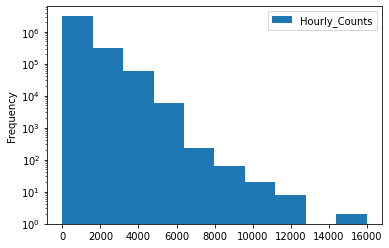

In [16]:
# Use pandas and plt to draw the histogram and set the log to true so that we can see the histogram with log-scale
ped_count_df.select('Hourly_Counts').toPandas().plot(kind = 'hist',log=True)

<strong>Average by month(Sum by day(Hourly Count))</strong>
* Group by the date 
* Calculate the total hourly_counts by f.sum
* Group by the Month
* Calculate the average number
* Sort the year and month
* Set Year and Month together as one value named Year-Month
* Drop Year and Month and keep the Year-Month
* Convert to Pandas to plot


In [17]:
# Steps to draw the line-plot (Prabha, 2020)
avg_day_by_month = ped_count_df.groupby(f.to_date('Date_Time').alias('Date'))\
                               .agg(f.sum('Hourly_Counts').alias('HC')) \
                               .groupby(f.year('Date').alias('Year'),f.month('Date').alias('Month'))\
                               .agg(f.avg('HC').alias('Average Daily Count Change by Month'))\
                               .sort('Year','Month')\
                               .withColumn('Year-Month',f.concat(f.col('Year'),f.lit('/'),f.col('Month')))\
                               .toPandas()

In [18]:
avg_day_by_month

,Year,Month,Average Daily Count Change by Month,Year-Month
0,2009,5,243178.645161,2009/5
1,2009,6,245335.733333,2009/6
2,2009,7,258944.903226,2009/7
3,2009,8,248581.580645,2009/8
4,2009,9,252346.200000,2009/9
...,...,...,...,...
134,2020,7,174031.096774,2020/7
135,2020,8,101861.322581,2020/8
136,2020,9,126311.866667,2020/9
137,2020,10,170160.612903,2020/10


/home/student/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:title={'center':'From 2009 to 2020 average daily counts per month'}, xlabel='Year-Month'>

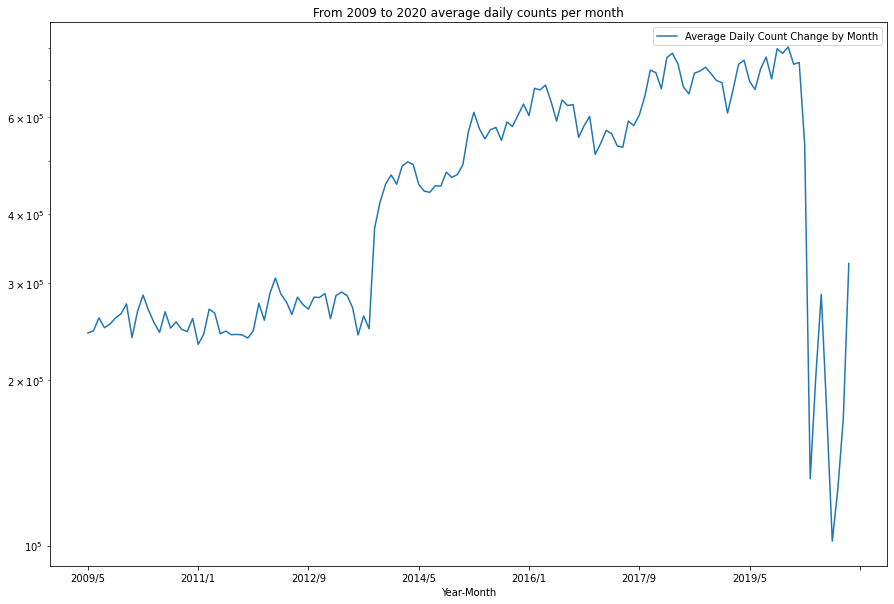

In [19]:
# Draw the graph with size 15,10 (Shetty, 2018)
avg_day_by_month.plot(kind = 'line',x = 'Year-Month', y = 'Average Daily Count Change by Month',logy = True,figsize = (15,10),title = "From 2009 to 2020 average daily counts per month")

#### 4. Explore the data provided and write code to present two plots worthy of presenting to the MelbourneGig company, describe your plots and discuss the findings from the plots
* Hint - 1: you can use the basic plots (e.g. histograms, line charts, scatter plots) for relationship between a column and the label; or more advanced plots like correlation plots; 2: if your data is too large for the plotting, consider using sampling before plotting
* 150 words max for each plot’s description and discussion
* Please do not repeat the plots in task 1.2.3.
* Please only use the provided data for visualisation

In [20]:
# Get the 0.1 sample otherwise the server will break (NNK, 2020)
ped_count_df_pdf = ped_count_df.sample(fraction=0.1).toPandas()

<strong>Plot description and discussion 01</strong>
> The plots below show the trend of hourly counts from Monday to Friday. The X axis represent the time. From Tuesday to Friday, the trends are similar as there is a small peak at around 11am, a small peak at around 2pm and the biggest peak at around 18pm. We can see that these three time show people will go out for relax and off-work time. There is a small different on Monday that the number of pedestrians is not similar to other weekday at around 18pm. People may stay longer at work as it is the first day of work.
From Saturday and Sunday, the time that the number of pedestrians grows is the time that people hanging around and enjoy the weekend


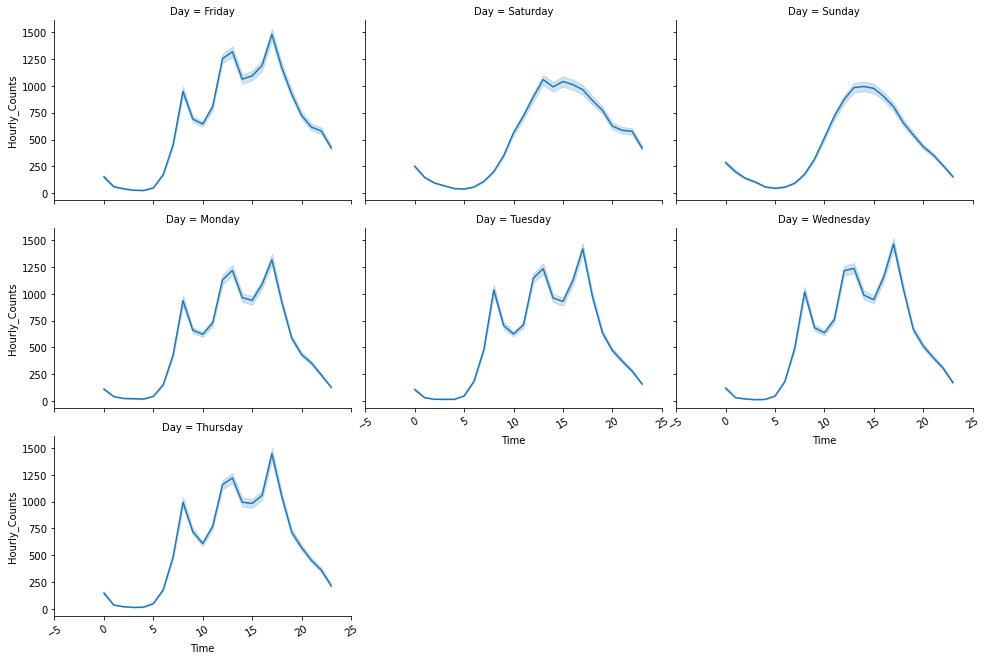

In [21]:
# Use relplot to show different trend in 7 days (Waskom, 2020)
g = sns.relplot(data=ped_count_df_pdf,x="Time",y="Hourly_Counts",col="Day",kind="line",col_wrap=3,height=3,aspect=1.5,legend=False)
g.set_xticklabels(rotation=30)

<strong>Plot description and discussion 02</strong>
> The plots below show the sensor id with the number of pedestrian counts from 2009 to 2020.
There are only 16 sensors in Melbourne in 2009. From 2013 the number of sensors grows fast. And we can see that start from 2015, sensor number 36 keeps the biggest pedestrian number which are Queen St (West). However, from 2019, the total number of pedestrians decrease rapidly and in 2020, the number presented the downward trend as the covid-19. People prefer stay at home for safety purpose. The future data can be predicted by the trend in 2019 and 2020 which will be more accuracy. 


In [22]:
# Get the sensor id with the hourly_counts
sen_id_num = ped_count_df.groupby(f.year('Date_Time').alias('Year'),f.col('Sensor_ID').alias('Sensor_ID'))\
                        .agg(f.sum('Hourly_Counts').alias('Sum Daily Count Change by Year'))\
                        .sort('Year','Sensor_ID')\
                        .withColumn('Year',f.concat(f.col('Year')))\
                        .toPandas()

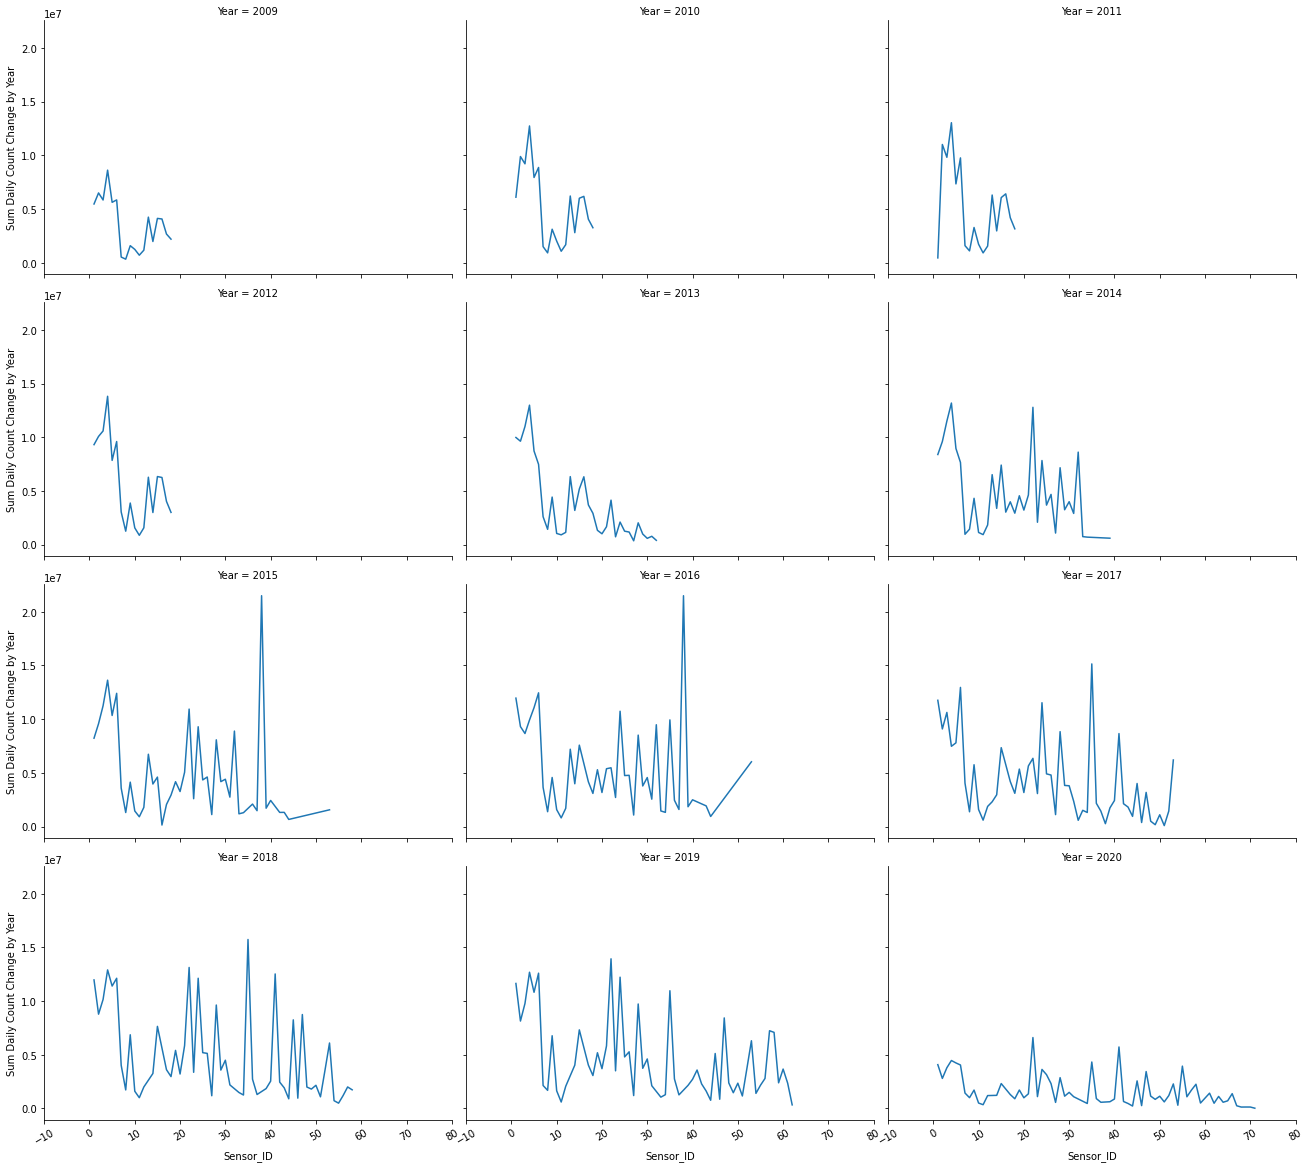

In [23]:
# Show the trend for each sensor in different year (Waskom, 2020)
b = sns.relplot(data=sen_id_num,x="Sensor_ID",y="Sum Daily Count Change by Year",col="Year",kind="line",col_wrap=3,height=4,aspect=1.5,legend=False)
b.set_xticklabels(rotation=30)

## 2. Feature extraction and ML training (70%)

### 2.1 Discuss the feature selection and prepare the feature columns (12%)

<strong>1. Considering the data exploration from 1.2 and the nature of time-series data, we would be performing a one-step time-series prediction, meaning that the model’s prediction for the next hour count would be based on the previous pedestrian count(s). And the prediction is only needed for the hours between 9:00am and midnight . Which columns are you planning to use as features? Discuss the reasons
for selecting them and how you create/transform them </strong>
* 400 words max for the discussion
* Please only use the provided data for model building
* Hint - things to consider include whether to create more feature columns, whether to remove some columns, using the insights from the data exploration/domain knowledge/statistical models

<strong> Discussion of 2.1.1</strong>
>The one-step time-series prediction is based on previous data counts. With more data that involved in the prediction, the more accuracy that the prediction can achieve.                              
For the selecting features, there are 11 columns in the <code>ped_count_df</code> dataset and 11 columns in the <code>sensor_loc_df</code> dataset. According to the requirement, the prediction only needed for the hours between 9:am and midnight. Then the <code>Year</code> is not suitable here. Instead, the <code>Month</code>, <code>Mdate</code>, <code>Day</code>, <code>Time</code>, <code>Date_Time</code> ,<code>Sensor_ID</code>, <code> Sensor_Name</code>, <code>Hourly_Counts</code>are more important.                           
For the dataset in <code>sensor_loc_df</code>, <code>Sensor_ID</code>, <code> Sensor_Name</code> can be dropped as they are duplicate. <code>latitude</code> and <code>longitude</code> can be keep as they show the direction of each sensor. On the other hand, the <code>location</code> can be removed.
A column <code>Avg_Hourly_Counts</code> need to be created to show the average counts for the last four hourly counts except the current one.   

* Refer to https://doi.org/10.1016/j.eswa.2012.01.039 , https://doi.org/10.1016/j.knosys.2018.10.009

#### 2. Write code to create the columns based on your discussion above

Window function is useful as it can group the data and show all of them rather than combaine them together. 
First partition by the sensor_id and order by date and time so that the hourly_count for sepcific sensor at specific time can list. Second, partition by the sensor_id and year for the rows from last 4 columns(without the current one), the avg_hourly_counts_5 can be showed which is for prediction

In [40]:
# Use window to partition the columns avoid data lost
# Get the difference and the hour for last four hourly_counts to do the prediction (Huai &amp; Armbrust, 2015)
from pyspark.sql.window import Window

Window1 = Window.partitionBy(['sensor_id']).orderBy('Date','Time')
Window2 = Window.partitionBy(['sensor_id','Year']).rowsBetween(-5,-1)

total_df = ped_count_df.join(sensor_loc_df,'sensor_id').drop(sensor_loc_df.sensor_id).drop(sensor_loc_df.sensor_name).drop(sensor_loc_df.sensor_description)\
                    .drop(sensor_loc_df.installation_date).drop(sensor_loc_df.note).drop(sensor_loc_df.direction_1).drop(sensor_loc_df.direction_2)\
                    .drop(sensor_loc_df.location).drop(sensor_loc_df.status).drop(ped_count_df.ID)\
                    .withColumn('Date',f.to_date('Date_Time'))\
                    .withColumn('Last_Hourly_Counts',f.lag('Hourly_Counts').over(Window1))\
                    .withColumn('Hourly_Difference',f.col('Hourly_Counts')-f.col('Last_Hourly_Counts'))\
                    .withColumn('Avg_Hourly_Counts_5',f.avg('Hourly_Counts').over(Window2))


In [41]:
total_df.columns

['Sensor_ID',
 'Date_Time',
 'Year',
 'Month',
 'Mdate',
 'Day',
 'Time',
 'Sensor_Name',
 'Hourly_Counts',
 'above_threshold',
 'latitude',
 'longitude',
 'Date',
 'Last_Hourly_Counts',
 'Hourly_Difference',
 'Avg_Hourly_Counts_5']

In [42]:
total_df.select('Sensor_ID','Date_Time','Hourly_Counts','Last_Hourly_Counts','Avg_Hourly_Counts_5','Hourly_Difference').show()

+---------+-------------------+-------------+------------------+-------------------+-----------------+
|Sensor_ID|          Date_Time|Hourly_Counts|Last_Hourly_Counts|Avg_Hourly_Counts_5|Hourly_Difference|
+---------+-------------------+-------------+------------------+-------------------+-----------------+
|       31|2013-10-09 00:00:00|           64|              null|               null|             null|
|       31|2013-10-09 01:00:00|           27|                64|               64.0|              -37|
|       31|2013-10-09 02:00:00|           10|                27|               45.5|              -17|
|       31|2013-10-09 03:00:00|            3|                10| 33.666666666666664|               -7|
|       31|2013-10-09 04:00:00|            8|                 3|               26.0|                5|
|       31|2013-10-09 05:00:00|            5|                 8|               22.4|               -3|
|       31|2013-10-09 06:00:00|           29|                 5|         

<strong>Check null value and remove them. From the data below, there are 454 null value in avg_hourly_counts_5 which all represent the first value each day. As data only need from 9am to midnight, these data can be droped</strong>

In [43]:
# Show the null value data
total_df.select([f.count(f.when(f.col(c).isNull(),c)).alias(c) for c in total_df.columns]).toPandas()

,Sensor_ID,Date_Time,Year,Month,Mdate,Day,Time,Sensor_Name,Hourly_Counts,above_threshold,latitude,longitude,Date,Last_Hourly_Counts,Hourly_Difference,Avg_Hourly_Counts_5
0,0,0,0,0,0,0,0,0,0,0,0,0,0,71,71,454


In [44]:
# Clean all null value
total_df = total_df.dropna(how = 'any')

In [45]:
total_df.select([f.count(f.when(f.col(c).isNull(),c)).alias(c) for c in total_df.columns]).toPandas()

,Sensor_ID,Date_Time,Year,Month,Mdate,Day,Time,Sensor_Name,Hourly_Counts,above_threshold,latitude,longitude,Date,Last_Hourly_Counts,Hourly_Difference,Avg_Hourly_Counts_5
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [46]:
total_df.printSchema()

root
 |-- Sensor_ID: integer (nullable = true)
 |-- Date_Time: timestamp (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- Mdate: integer (nullable = true)
 |-- Day: string (nullable = true)
 |-- Time: integer (nullable = true)
 |-- Sensor_Name: string (nullable = true)
 |-- Hourly_Counts: integer (nullable = true)
 |-- above_threshold: integer (nullable = false)
 |-- latitude: float (nullable = true)
 |-- longitude: float (nullable = true)
 |-- Date: date (nullable = true)
 |-- Last_Hourly_Counts: integer (nullable = true)
 |-- Hourly_Difference: integer (nullable = true)
 |-- Avg_Hourly_Counts_5: double (nullable = true)



In [47]:
# Check the type of each data
print([c[0] for c in total_df.dtypes if c[1] == 'string'])
print([c[0] for c in total_df.dtypes if c[1] == 'int'])
print([c[0] for c in total_df.dtypes if c[1] == 'double'])
print([c[0] for c in total_df.dtypes if c[1] == 'float'])

['Month', 'Day', 'Sensor_Name']
['Sensor_ID', 'Year', 'Mdate', 'Time', 'Hourly_Counts', 'above_threshold', 'Last_Hourly_Counts', 'Hourly_Difference']
['Avg_Hourly_Counts_5']
['latitude', 'longitude']


### 2.2 Preparing Spark ML Transformers/Estimators for features, labels and models (16%)

#### 1. Write code to create Transformers/Estimators for transforming/assembling the columns you selected above in 2.1, and create ML model Estimators for Decision Tree and Gradient Boosted Tree model for each use case

Choose the inputCols from <code>total_df</code>. Already distinct the string and non-string value. As discussed, <code>Year</code> can not be included and <code>above_threhold</code> and <code>Hourly_counts</code> and <code>Hourly_difference</code> all contain the data that need to predicte. These three values can not be in the inputCols as well. However,in the question 2.3, the data between 2013 to 2018 need to use for training purpose, <code>Year</code> need to keep.


In [48]:
# Get the non_numer column (session 6)
from pyspark.ml.feature import StringIndexer
non_num_col = ['Month', 'Day']
num_col = ['Sensor_ID', 'Year','Mdate', 'Time', 'Last_Hourly_Counts','Avg_Hourly_Counts_5', 'latitude', 'longitude']

inputCols = non_num_col
outputCols = [f'{x}_index' for x in non_num_col]
              
indexer = StringIndexer(inputCols = inputCols, outputCols = outputCols)

In [49]:
# Using OneHotEncoder to convert it to numeric representation (session 6)
from pyspark.ml.feature import OneHotEncoder
inputCols_OHE = [x for x in outputCols]#all output columns from StringIndexer exept the Income
outputCols_OHE = [f'{x}_vec' for x in inputCols]

#Define OneHotEncoder with the appropriate columns
encoder =OneHotEncoder(inputCols = inputCols_OHE, outputCols=outputCols_OHE)

In [50]:
# Assemble our attributes into one column using Spark’s VectorAssembler (session 6)
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler

inputCols_ASB = num_col + outputCols_OHE
assembler = VectorAssembler(inputCols = inputCols_ASB, outputCol = 'feature')
scaler = StandardScaler(inputCol = 'feature', outputCol = 'featureScaled')

In [51]:
inputCols_ASB

['Sensor_ID',
 'Year',
 'Mdate',
 'Time',
 'Last_Hourly_Counts',
 'Avg_Hourly_Counts_5',
 'latitude',
 'longitude',
 'Month_vec',
 'Day_vec']

#### 2. Write code to include the above Transformers/Estimators into pipelines
* A maximum of two pipelines can be created for each use case

In [52]:
# Assemble the above steps of transformation into a Pipeline (session 5)
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = [indexer,encoder,assembler,scaler])

#### After add to pipeline, fit and transform the pipeline

In [ ]:
pipeline_model = pipeline.fit(total_df)
final_df = pipeline_model.transform(total_df)

In [53]:
final_df['featureScaled','above_threshold'].show()

+--------------------+---------------+
|       featureScaled|above_threshold|
+--------------------+---------------+
|(25,[0,1,2,3,4,5,...|              0|
|(25,[0,1,2,3,4,5,...|              0|
|(25,[0,1,2,3,4,5,...|              0|
|(25,[0,1,2,3,4,5,...|              0|
|(25,[0,1,2,3,4,5,...|              0|
|(25,[0,1,2,3,4,5,...|              0|
|(25,[0,1,2,3,4,5,...|              0|
|(25,[0,1,2,3,4,5,...|              0|
|(25,[0,1,2,3,4,5,...|              0|
|(25,[0,1,2,3,4,5,...|              0|
|(25,[0,1,2,3,4,5,...|              0|
|(25,[0,1,2,3,4,5,...|              0|
|(25,[0,1,2,3,4,5,...|              0|
|(25,[0,1,2,3,4,5,...|              0|
|(25,[0,1,2,3,4,5,...|              0|
|(25,[0,1,2,3,4,5,...|              0|
|(25,[0,1,2,3,4,5,...|              0|
|(25,[0,1,2,3,4,5,...|              0|
|(25,[0,1,2,3,4,5,...|              0|
|(25,[0,1,2,3,4,5,...|              0|
+--------------------+---------------+
only showing top 20 rows



####  3. For the Decision Tree classification model you have created, explain the purposes of the hyperparameters of maxDepth and maxBin, and how they impact the model in theory and in this use case

>MaxDepth is to control the maximum depth of the tree. If the maxDepth is too large, it will cause the overfitting and have longer trianing time. Maxbin is the maximum number of features to consider at each split. Once the number of maxBin increasing, there will be more split candidates. But the if maxBin have large number, the computation will increase as well


## 2.3 Preparing the training data and testing data (4%)

### 1. Write code to split the data for training and testing purpose - use the data between 2014 and 2018 (including 2018) for training purpose and the data in 2019 as testing purpose ; then cache the training and testing data
* Note: From task 2.1.1, the model training and the prediction is only needed for the hours between 9:00am and midnight .

In [56]:
# Filter the data to between 2014 to 2018 and the time to from 9am to midnight and data in 2019 as the test data
train = final_df.filter(f.col('Year').between(2014,2018))\
               .filter((f.col('Time')==0)|(f.col('Time')>=9))

test = final_df.filter(f.col('Year')==2019)\
               .filter((f.col('Time')==0)|(f.col('Time')>=9))

In [57]:
# Show the count number for above threshold and below threshold from train data 
train.groupBy('above_threshold').count().show()

+---------------+-------+
|above_threshold|  count|
+---------------+-------+
|              1| 135088|
|              0|1041130|
+---------------+-------+



In [59]:
# Show the count number for above threshold and below threshold from test data 
test.groupBy('above_threshold').count().show()

+---------------+------+
|above_threshold| count|
+---------------+------+
|              1| 31047|
|              0|273459|
+---------------+------+



## 2.4 Training and evaluating models (38%)

### 1. For use case 1, write code to use the corresponding ML Pipelines to train the models on the training data from 2.3. And then use the trained models to perform predictions on the testing data from 2.3



In [ ]:
#  Using the Decision Tree(Session 6)
from pyspark.ml.classification import DecisionTreeClassifier
# Extracts the number of nodes in the decision tree and the tree depth in the model and stores it in dt.
dt = DecisionTreeClassifier(featuresCol = 'featureScaled', labelCol = 'above_threshold', maxDepth = 8)

In [ ]:
#  Using the GBT (GBTClassifier, 2020)
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(featuresCol='feature',labelCol='above_threshold',maxIter=10)

In [60]:
# Fit and transform the train and test data using decision tree(Session 06)
Decision_Tree_model = dt.fit(train)
Decision_Tree_Predictions = Decision_Tree_model.transform(test)

In [61]:
# Fit and transform the train and test data using gbt (GBTClassifier, 2020)
gb_tree = gbt.fit(train)
gb_tree_predictions = gb_tree.transform(test)

### 2. For both models’ results in use case 1, write code to display the count of each combination of above threshold/below-threshold label and prediction label in formats like the screenshot below. Compute the AUC, accuracy, recall and precision for the above-threshold/below-threshold label from each model testing result using pyspark MLlib/ML APIs
* Discuss which metric is more proper for measuring the model performance on predicting above-threshold events, in order to give the performers good recommendations while reducing the chance of falsely recommending a location.
* Discuss which is the better model, and persist the better model.

In [62]:
Decision_Tree_Predictions.groupBy('above_threshold','prediction').count().show()

+---------------+----------+------+
|above_threshold|prediction| count|
+---------------+----------+------+
|              1|       0.0|  4309|
|              0|       0.0|270002|
|              1|       1.0| 26738|
|              0|       1.0|  3457|
+---------------+----------+------+



In [63]:
gb_tree_predictions.groupBy('above_threshold','prediction').count().show()

+---------------+----------+------+
|above_threshold|prediction| count|
+---------------+----------+------+
|              1|       0.0|  5243|
|              0|       0.0|269231|
|              1|       1.0| 25804|
|              0|       1.0|  4228|
+---------------+----------+------+



In [64]:
# To calculateaccuracy, recall and precision by define the function compute_metrics (Session 06)
def compute_metrics(predictions):
    #WRITE CODE: to calculate accuracy,precision,recall and f1 based on above example
    TN =predictions.filter('prediction = 0 AND above_threshold = 0').count()
    TP =predictions.filter('prediction = 1 AND above_threshold = 1').count()
    FN =predictions.filter('prediction = 0 AND above_threshold = 1').count()
    FP =predictions.filter('prediction = 1 AND above_threshold = 0').count()
    accuracy = (TP+TN)/(TN+TP+FN+FP)# formula to find accuracy
    precision = TP/(TP+FP)# formula to find precision
    recall = TP/(TP+FN)# formula to find recall
    f1 = 2/(1/recall+1/precision)# formula to find F1-score

    return accuracy,precision,recall,f1    

In [65]:
# Print the accuracy,precision,recall and f1 scores for each Classification algorithm
import pandas as pd
d = dict(zip(['Decison Tree', 'Gradient Boosted Tree',],
           [compute_metrics(Decision_Tree_Predictions), compute_metrics(gb_tree_predictions)]))
metrics_df = pd.DataFrame(data = d, index = ['accuracy','precision','recall','f1'])
metrics_df

,Decison Tree,Gradient Boosted Tree
accuracy,0.974496,0.968897
precision,0.885511,0.859217
recall,0.861210,0.831127
f1,0.873192,0.844939


In [66]:
# Use BinaryClassificationEvaluator to evaluate a model (Session 06)
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model Decision Tree
evaluator = BinaryClassificationEvaluator(labelCol = 'above_threshold')
auc_dt = evaluator.evaluate(Decision_Tree_Predictions)
print(evaluator.getMetricName())
print(auc_dt)

areaUnderROC
0.9231811103471481


In [67]:
# Evaluate GBT
auc_dt_gbt = evaluator.evaluate(gb_tree_predictions)
print(evaluator.getMetricName())
print(auc_dt_gbt)

areaUnderROC
0.989464157295677


### 3. For the Decision Tree classification model in use case 1, write code to print out the leaf node splitting criteria and the top-3 features with each corresponding feature importance. Describe the result in a way that it could be understood by your potential users (e.g. street art performers)

In [68]:
# To show the leaf node splitting criteria by using to DebugString(How to extract feature information for tree-based Apache SparkML pipeline models, 2020)
print(Decision_Tree_model.toDebugString)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_f4f61de2dbf9, depth=8, numNodes=307, numClasses=2, numFeatures=25
  If (feature 4 <= 2.410363822958348)
   If (feature 4 <= 1.6330461864049257)
    If (feature 4 <= 1.4441191039701782)
     If (feature 4 <= 1.2724794669869761)
      If (feature 4 <= 1.1354147209068652)
       Predict: 0.0
      Else (feature 4 > 1.1354147209068652)
       If (feature 7 <= 17124.994192815822)
        If (feature 3 <= 2.232565578723234)
         If (feature 0 <= 0.7701947311157421)
          Predict: 0.0
         Else (feature 0 > 0.7701947311157421)
          Predict: 1.0
        Else (feature 3 > 2.232565578723234)
         If (feature 3 <= 2.3766020676731205)
          Predict: 1.0
         Else (feature 3 > 2.3766020676731205)
          Predict: 0.0
       Else (feature 7 > 17124.994192815822)
        Predict: 0.0
     Else (feature 4 > 1.2724794669869761)
      If (feature 7 <= 17124.994192815822)
       If (feature 3 <= 2.232565578723234)


Using bubble sort to sort the list so that the top-3 features can be found. As the list contains tuple, bubble sort need to modified to 

<code>if nums[j][1] nums[j + 1][1]</code>

In [69]:
# Use bubble sort to get the top feature ( Valdarrama, 2020)
def bubble_sort(nums):
    for i in range(len(nums) - 1):
        for j in range(len(nums) - i - 1): 
            if nums[j][1] < nums[j + 1][1]:
                nums[j], nums[j + 1] = nums[j + 1], nums[j]
    return nums

From the pipline model to get the input cols and use featureImportances to find the importance of each feature. Zip them together to be a list and use bubble sort to get the top-3 feature

In [70]:
# In order to get feature importance, use the featureImportances to get the number and zip it with feature. 
# Use bubble sort to get the top-3(Brownlee, 2020)
inputCols_pip = pipeline_model.stages[2].getInputCols()
feature_important = Decision_Tree_model.featureImportances
feature_list = list(zip(inputCols_pip,feature_important))
top_feature = bubble_sort(feature_list)

In [79]:
top_feature[:3]

[('Last_Hourly_Counts', 0.7747443108413046),
 ('Time', 0.15586213191426906),
 ('Sensor_ID', 0.024319812620208183)]

### 4. How to improve the prediction for use case 1? Propose at least two suggestions, elaborate on why each could improve the models, and also briefly explain how to implement it with code snippets (no need for full implementation)
* Hint - your suggestion should assume that model training is run on a Spark
cluster with the data being in either Spark RDD or Dataframe format; you can
also suggest using additional packages which are compatible with Spark.
* 600 words max for the discussion

>From use case 1, Decision Tree and Gradient Boosted Tree model are used. However, from the above threshold count, data is imbalance. As we can see from the 2.3.1, the number of above thresholds is 135088 and below threshold is 1041130. The huge difference influences the result. The way to solve these is to give more data and add more feature to improve the data variety and volume. Furthermore, create more data based on exist data is another idea to improve the data variety. Or we can use code to re-balance the data like:
```python
new_train = train[train[label] == 0].sample(fraction = train[train(label)==1].count()/train[train[label] == 0].count)
```
which get the similar  number of above_threshold and below_threshold. These is one solution to solve the data imbalance.
To compare different model, better use precision-recall graph rather than ROC as ROC will ignore the real situation when the value of AUC is too high. 

>On the other hand, the feature chose is important as well. From the input features, we have <code> Last_Hourly_Counts</code>, <code>Time</code>, <code>Sensor_ID</code>, <code>Longitude</code>, <code>Avg_Hourly_Counts_5 </code> which are top 5 feature importance. But the top 1 feature which is the <code> Last_Hourly_Counts</code> has 77.58% importance and <code>Time</code> has 15.76% importance. It can be concluded that the prediction is depend on these two feature which is not suitable. More features need to added to the model so that the prediction can reply on more rather than just these two. 



### Use case 2
### 5. For use case 2, write code to use the corresponding ML Pipelines to train the models on the cache training data from 2.3. And then use the trained models to perform predictions on the testing data from 2.3

In [80]:
# By using the regression to train the model of decision tree and GBT
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

In [73]:
# Get the featurescaled and hourly_counts to fit and transform for decision tree (Source code for pyspark.ml.regression)
decision_tree_reg = DecisionTreeRegressor(featuresCol = 'featureScaled', labelCol='Hourly_Counts')
decision_tree_reg_model = decision_tree_reg.fit(train)
decision_tree_reg_pre = decision_tree_reg_model.transform(test)

In [81]:
## Get the featurescaled and hourly_counts to fit and transform for GBT (Source code for pyspark.ml.regression)
GBT_reg = GBTRegressor(featuresCol='feature',labelCol='Hourly_Counts')
GBT_reg_model = GBT_reg.fit(train)
GBT_red_pre = GBT_reg_model.transform(test)

In [76]:
#Show the prediction with the actual data
decision_tree_reg_pre.select('prediction','Hourly_Counts').show(20)

+------------------+-------------+
|        prediction|Hourly_Counts|
+------------------+-------------+
| 44.54900269398697|           64|
| 44.54900269398697|          119|
|105.86487318561714|          225|
|216.06773913043477|          277|
| 322.1467054815471|          360|
|479.25604077971263|          501|
|479.25604077971263|          514|
| 663.4777472449645|          422|
|479.25604077971263|          452|
| 337.5951709883502|          545|
| 460.4420888374721|          646|
| 460.4420888374721|          763|
| 620.1005250760625|          746|
| 620.1005250760625|          553|
| 460.4420888374721|          270|
| 322.1467054815471|           83|
|105.86487318561714|          109|
|105.86487318561714|          119|
|105.86487318561714|          194|
|216.06773913043477|          274|
+------------------+-------------+
only showing top 20 rows



In [82]:
#Show the prediction with the actual data
GBT_red_pre.select('prediction','Hourly_Counts').show(20)

+------------------+-------------+
|        prediction|Hourly_Counts|
+------------------+-------------+
| 54.63313923988588|           64|
| 85.98579306426585|          119|
|178.17869198222678|          225|
| 350.3574704503555|          277|
| 219.7002945355888|          360|
| 256.0669640409844|          501|
|460.64452562975725|          514|
|  554.121244585105|          422|
| 525.7420245675452|          452|
|  444.519827467134|          545|
| 434.3205915305879|          646|
| 535.9435169674672|          763|
| 674.0131453337457|          746|
|  512.500667264469|          553|
|  327.764859248563|          270|
|120.97374139694136|           83|
| 54.63313923988588|          109|
|155.72112599359457|          119|
|178.17869198222678|          194|
| 350.3574704503555|          274|
+------------------+-------------+
only showing top 20 rows



In [77]:
# compute the RMSE(Session 08)
decision_tree_reg_eva = RegressionEvaluator(labelCol='Hourly_Counts',predictionCol = 'prediction', metricName = 'rmse')
rmse = decision_tree_reg_eva.evaluate(decision_tree_reg_pre)
print('Root Mean Squared Error on test data = %g'%rmse)

Root Mean Squared Error on test data = 313.077


In [78]:
# computer the R-squared by using RegressionEvaluator(Li, 2018)
decision_tree_reg_eva = RegressionEvaluator(labelCol='Hourly_Counts',predictionCol = 'prediction', metricName = 'r2')
r2 = decision_tree_reg_eva.evaluate(decision_tree_reg_pre)
print('R Square on test data = %g'%r2)

R Square on test data = 0.868602


In [83]:
# compute the RMSE(Session 08)
GBRT_reg_eva = RegressionEvaluator(labelCol='Hourly_Counts',predictionCol = 'prediction', metricName = 'rmse')
rmse = GBRT_reg_eva.evaluate(GBT_red_pre)
print('Root Mean Squared Error on test data for GBT = %g'%rmse)

Root Mean Squared Error on test data for GBT = 248.626


In [84]:
# computer the R-squared by using RegressionEvaluator(Li, 2018)
GBRT_reg_eva = RegressionEvaluator(labelCol='Hourly_Counts',predictionCol = 'prediction', metricName = 'r2')
r2 = GBRT_reg_eva.evaluate(GBT_red_pre)
print('R Square on test data  for GBT  = %g'%r2)

R Square on test data  for GBT  = 0.917133


### 6. For both models’ results in use case 2, compute the RMSE, R-squared
* Discuss which is the better model, and persist the better model

<strong>Discussion of 2.4.6</strong>
>From the result of R-squared, decision tree get 0.868 and gbt get 0.9171. As R-squared means that if it is equal to 1 then the model has 100% accuracy, if it is equal to 0 then the model is not help at all. The R-squared of gbt is larger than decision tree. And for the RMSE, GBT got 248.62 which is smaller than the decision tree which is 313.077. From the data above, Gradient Boosted Tree is the better model

In [87]:
# Save the model (Session 07)
GBT_reg_model.save('GBT_Regression_prediction_model')

## 3. Knowledge sharing (6%)

### 3.1 How many jobs are observed when training the KMeans clustering model following the code below? Provide a screenshot from Spark UI for running a simple KMeans model training from the provided data

In [307]:
spark.stop()
spark = SparkSession.builder.master('local[*]').appName('Assignment2A_3.1').getOrCreate()

In [309]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans

customer_df = spark.createDataFrame([
(0,19,15,39),
(0,21,15,81),
(1,20,16,6),
(1,23,16,77),
(1,31,17,40),
(1,22,17,76),
(1,35,18,6),
(1,23,18,94),
(0,64,19,3),
(1,30,19,72),
(0,67,19,14),
(1,35,19,99),
(1,58,20,15)],
['gender', 'age', 'annual_income', 'spending_score'])
assembler = VectorAssembler(
inputCols=['gender', 'age', 'annual_income', 'spending_score'],
outputCol='features')
kmeans = KMeans(k=4).fit(assembler.transform(customer_df))

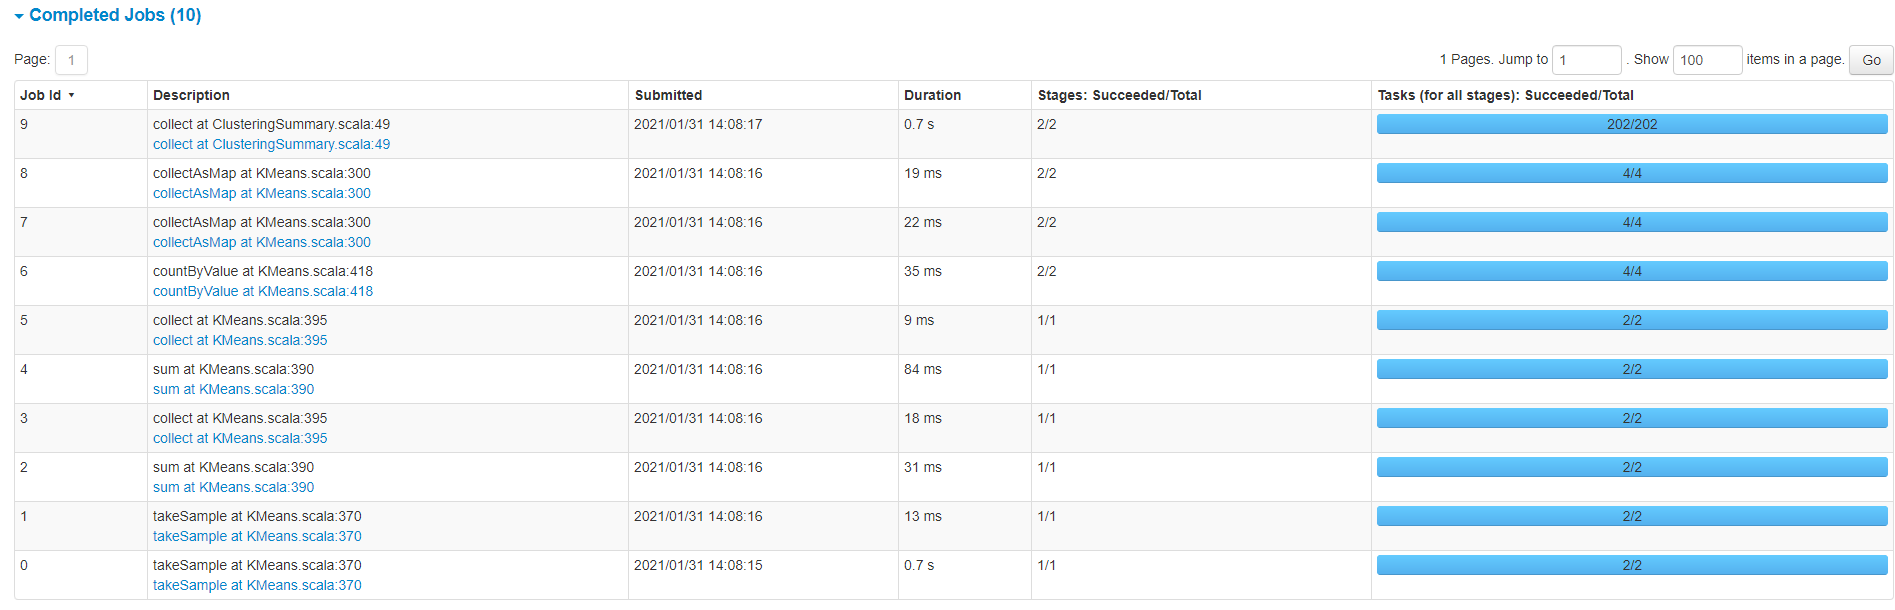

### 3.2 Combining the parallelism theory from lecture, Spark source code, and the Spark UI, explain whether data parallelism or result parallelism is being adopted in the implementation of KMeans clustering in Spark (5%)
* 300 words max for the discussion
* Hint - you can also refer to the Spark source code on github https://github.com/apache/spark/blob/master/mllib/src/main/scala/org/apache/spark/mllib/clustering/KMeans.scala


<strong>Discussion of 3.2</strong>
>As for data parallelism is to distribute data through different nodes and all data are operated in parallel. it creates parallelism from the beginning of the partition because of the partition of the dataset. Result parallelism actually based on the target clusters. In data parallelism, data is partitioned into multiple partitions. Each processor will work independently. After processing complete, union the same cluster to get the final cluster. In result parallelism, each processor will work one each cluster. From the very beginning, one processor only creates one cluster. 
For KMeans clustering in Spark, it is good at paralleling and iterative. In the Spark source code, the <code>countbyValue</code> is to make the operation simple. KMeans will count the distance by <code>distanceMeasure</code> and add to the closest cluster and do the calculation until no longer change. According to this, KMeans is result parallelism



# Reference

N.N.K. (2019, November 8). Spark schema – explained with examples. Sparkbyexamples. https://sparkbyexamples.com/spark/spark-schema-explained-with-examples/

Prabha. (2020, August 30). PySpark concatenate columns. Sparkbyexamples. https://sparkbyexamples.com/pyspark/pyspark-concatenate-columns/

Shetty, B. (2018, November 12). Data Visualization using Matplotlib. Towardsdatascience. https://towardsdatascience.com/data-visualization-using-matplotlib-16f1aae5ce70

N.N.K. (2020, November 27). PySpark Random Sample with Example. Sparkbyexamples. https://sparkbyexamples.com/pyspark/pyspark-sampling-example/

WaskomMichael. (2020). seaborn.relplot. seaborn: https://seaborn.pydata.org/generated/seaborn.relplot.html

Huai, Y., &amp; Armbrust, M. (2015, July 15). Introducing Window Functions in Spark SQL. from https://databricks.com/blog/2015/07/15/introducing-window-functions-in-spark-sql.html

Session 05 Tutorial, FIT5202 Spark ML - Transformer, Estimator and Pipeline, FIT5202 Part A - K-Means Clustering

Session 06 Tutorial, FIT5202 Classification Algorithms

Session 08 Tutorial, FIT5202 - Collaborative Filtering [V 1.0]

Session 07 Tutorial, FIT5202 Part B - Model Selection and Persistence

Org.apache.spark.ml.classification - Class GBTClassifier. (2020, August 28). Retrieved January 31, 2021, from https://spark.apache.org/docs/latest/api/java/org/apache/spark/ml/classification/GBTClassifier.html

How to extract feature information for tree-based Apache SparkML pipeline models. (2020, March 23). Retrieved January 31, 2021, from https://kb.databricks.com/machine-learning/extract-feature-info.html

Valdarrama, S. (2020, April 15). Sorting Algorithms in Python. Retrieved January 31, 2021, from https://realpython.com/sorting-algorithms-python/

Brownlee, J. (2020, March 30). How to Calculate Feature Importance With Python. Retrieved January 31, 2021, from https://machinelearningmastery.com/calculate-feature-importance-with-python/#:~:text=Feature%20importance%20refers%20to%20a,feature%20when%20making%20a%20prediction.&amp;text=Reducing%20the%20number%20of%20input%20features.

Source code for pyspark.ml.regression. (n.d.). Retrieved January 31, 2021, from https://spark.apache.org/docs/1.5.2/api/python/_modules/pyspark/ml/regression.html

Li, S. (2018, May 1). Building A Linear Regression with PySpark and MLlib. Retrieved January 31, 2021, from https://towardsdatascience.com/building-a-linear-regression-with-pyspark-and-mllib-d065c3ba246a